This notebook plots maps of 2016-mean precipitation bias in prognostic runs. It depends on diagnostics computed by the `prognostic-reports` workflow.

It generates Figure 4 and Figure S3.

In [1]:
import xarray as xr
import fsspec
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
import numpy as np
import cartopy.crs as ccrs
matplotlib.rcParams['figure.dpi'] = 300
xr.set_options(keep_attrs=True)

### Load time-mean lat-lon diagnostics for three runs

In [2]:
urls = {
    'baseline': 'gs://vcm-ml-public/argo/2020-11-10-n2o-climate-runs/baseline/diags_latlon.nc',
    'rf-control': 'gs://vcm-ml-public/argo/2021-03-15-n2o-climate-runs/rf-control/diags_latlon.nc',
    'rf-dQ1-dQ2-only': 'gs://vcm-ml-public/argo/2021-03-15-n2o-climate-runs/rf-dQ1-dQ2-only/diags_latlon.nc',
}

In [3]:
diags = []
for run, url in urls.items():
    with fsspec.open(url) as f:
        ds = xr.open_dataset(f).load()
        diags.append(ds.assign_coords(experiment=run))
diags = xr.concat(diags, dim='experiment')

In [4]:
def global_rmse(ds):
    w = np.cos(np.deg2rad(ds.latitude))
    squared_errors = ds ** 2
    zonal_mean_squared_errors = squared_errors.mean('longitude')
    mean_squared_errors = (zonal_mean_squared_errors * w).sum('latitude') / w.sum('latitude')
    return np.sqrt(mean_squared_errors)


def global_bias(ds):
    w = np.cos(np.deg2rad(ds.latitude))
    zonal_mean_bias = ds.mean('longitude')
    return (zonal_mean_bias * w).sum('latitude') / w.sum('latitude')

### Compute global-mean RMSE and bias of time-mean maps

In [5]:
bias_variables = [v for v in diags if 'time_mean_bias' in v]
rmse_df = global_rmse(diags[bias_variables]).to_dataframe().T
bias_df = global_bias(diags[bias_variables]).to_dataframe().T

### Now compare precipitation with GPCP

Taking $P-<dQ2>$ as precipitation from prognostic runs.

In [6]:
url_gpcp = 'gs://vcm-ml-raw/2020-11-10-GPCP-2015-2016/gpcp_v01r03_daily.zarr'
m = fsspec.get_mapper(url_gpcp)
ds_gpcp = xr.open_zarr(m, consolidated=True)
# shift lat/lon labels to center of grid cells
ds_gpcp = ds_gpcp.assign_coords(latitude=ds_gpcp.latitude + 0.5, longitude=ds_gpcp.longitude + 0.5)

In [7]:
model_precip = diags['total_precip_time_mean_value']
end_time = model_precip.attrs['diagnostic_end_time']
# verification = forecast - bias
verif_precip = (diags.total_precip_time_mean_value - diags.total_precip_time_mean_bias)
verif_precip = verif_precip.sel(experiment="baseline").assign_coords(experiment='nudged run')
gpcp_precip = ds_gpcp['precip'].sel(time='2016').mean('time').rename('total_precip_time_mean_value').compute()
precip = xr.concat([gpcp_precip.assign_coords(experiment='GPCP'), verif_precip, model_precip], dim='experiment', join='override')
precip = precip.assign_attrs(long_name='total precipitation')

In [8]:
map_proj = ccrs.Robinson(central_longitude=180)
aspect = diags.dims['longitude'] / diags.dims['latitude']
plot_kwargs = dict(transform=ccrs.PlateCarree(), subplot_kws={'projection': map_proj}, aspect=aspect)

In [9]:
precip_bias_from_GPCP = (precip - precip.sel(experiment='GPCP')).assign_attrs(long_name='precipitation difference from GPCP')
precip_rmse = global_rmse(precip_bias_from_GPCP).to_dataframe(name='precip_rmse').T
precip_global_bias = global_bias(precip_bias_from_GPCP).to_dataframe(name='precip_bias').T

### Figure 4

Plot just baseline and rf-control

/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


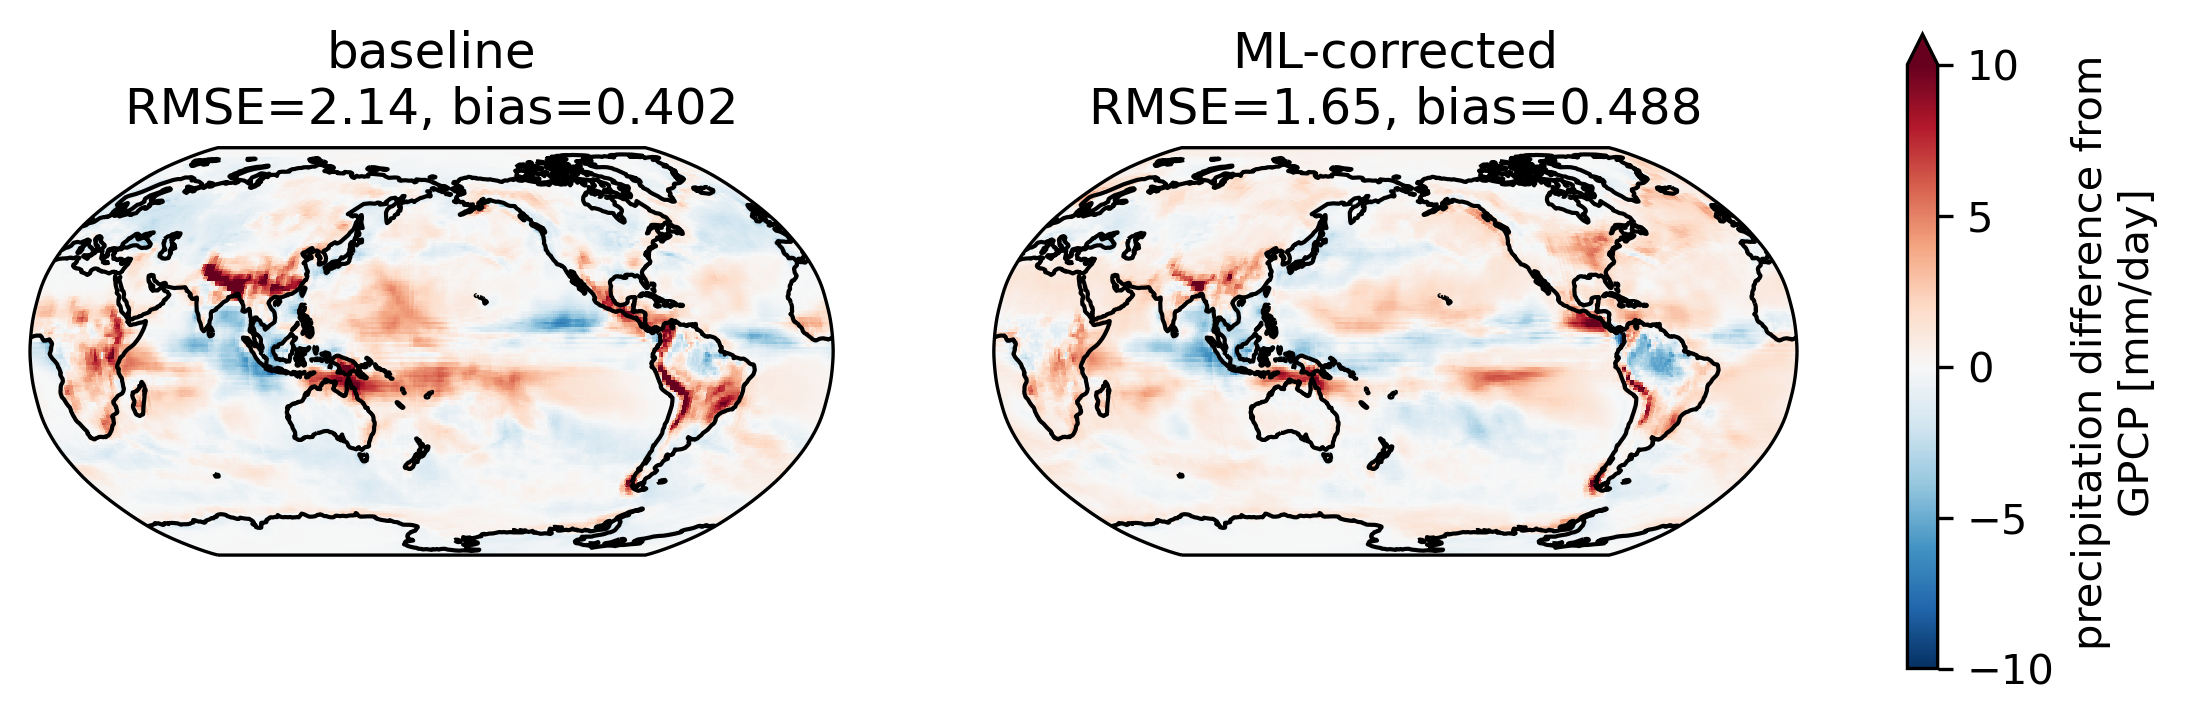

In [10]:
runs = ['baseline', 'rf-control']
run_titles = {
    'nudged run': 'nudged run',
    'baseline': 'baseline',
    'rf-control': 'ML-corrected',
    'rf-dQ1-dQ2-only': 'ML-corrected ($\Delta Q_1$, $\Delta Q_2$ only)'
}
fg = precip_bias_from_GPCP.sel(experiment=runs).plot(col='experiment', robust=True, vmin=-10, vmax=10, cmap='RdBu_r', **plot_kwargs)
for ax in fg.axes.flat:
    ax.coastlines()
for i, run in enumerate(precip_bias_from_GPCP.sel(experiment=runs).experiment):
    run_label = run.values.item()
    rmse = precip_rmse[run_label]['precip_rmse']
    bias = precip_global_bias[run_label]['precip_bias']
    fg.axes.flat[i].set_title(f"{run_titles[run_label]}\nRMSE={rmse:.3}, bias={bias:.3}")
fg.fig.set_size_inches(9.5, 2.8)

### Figure S4

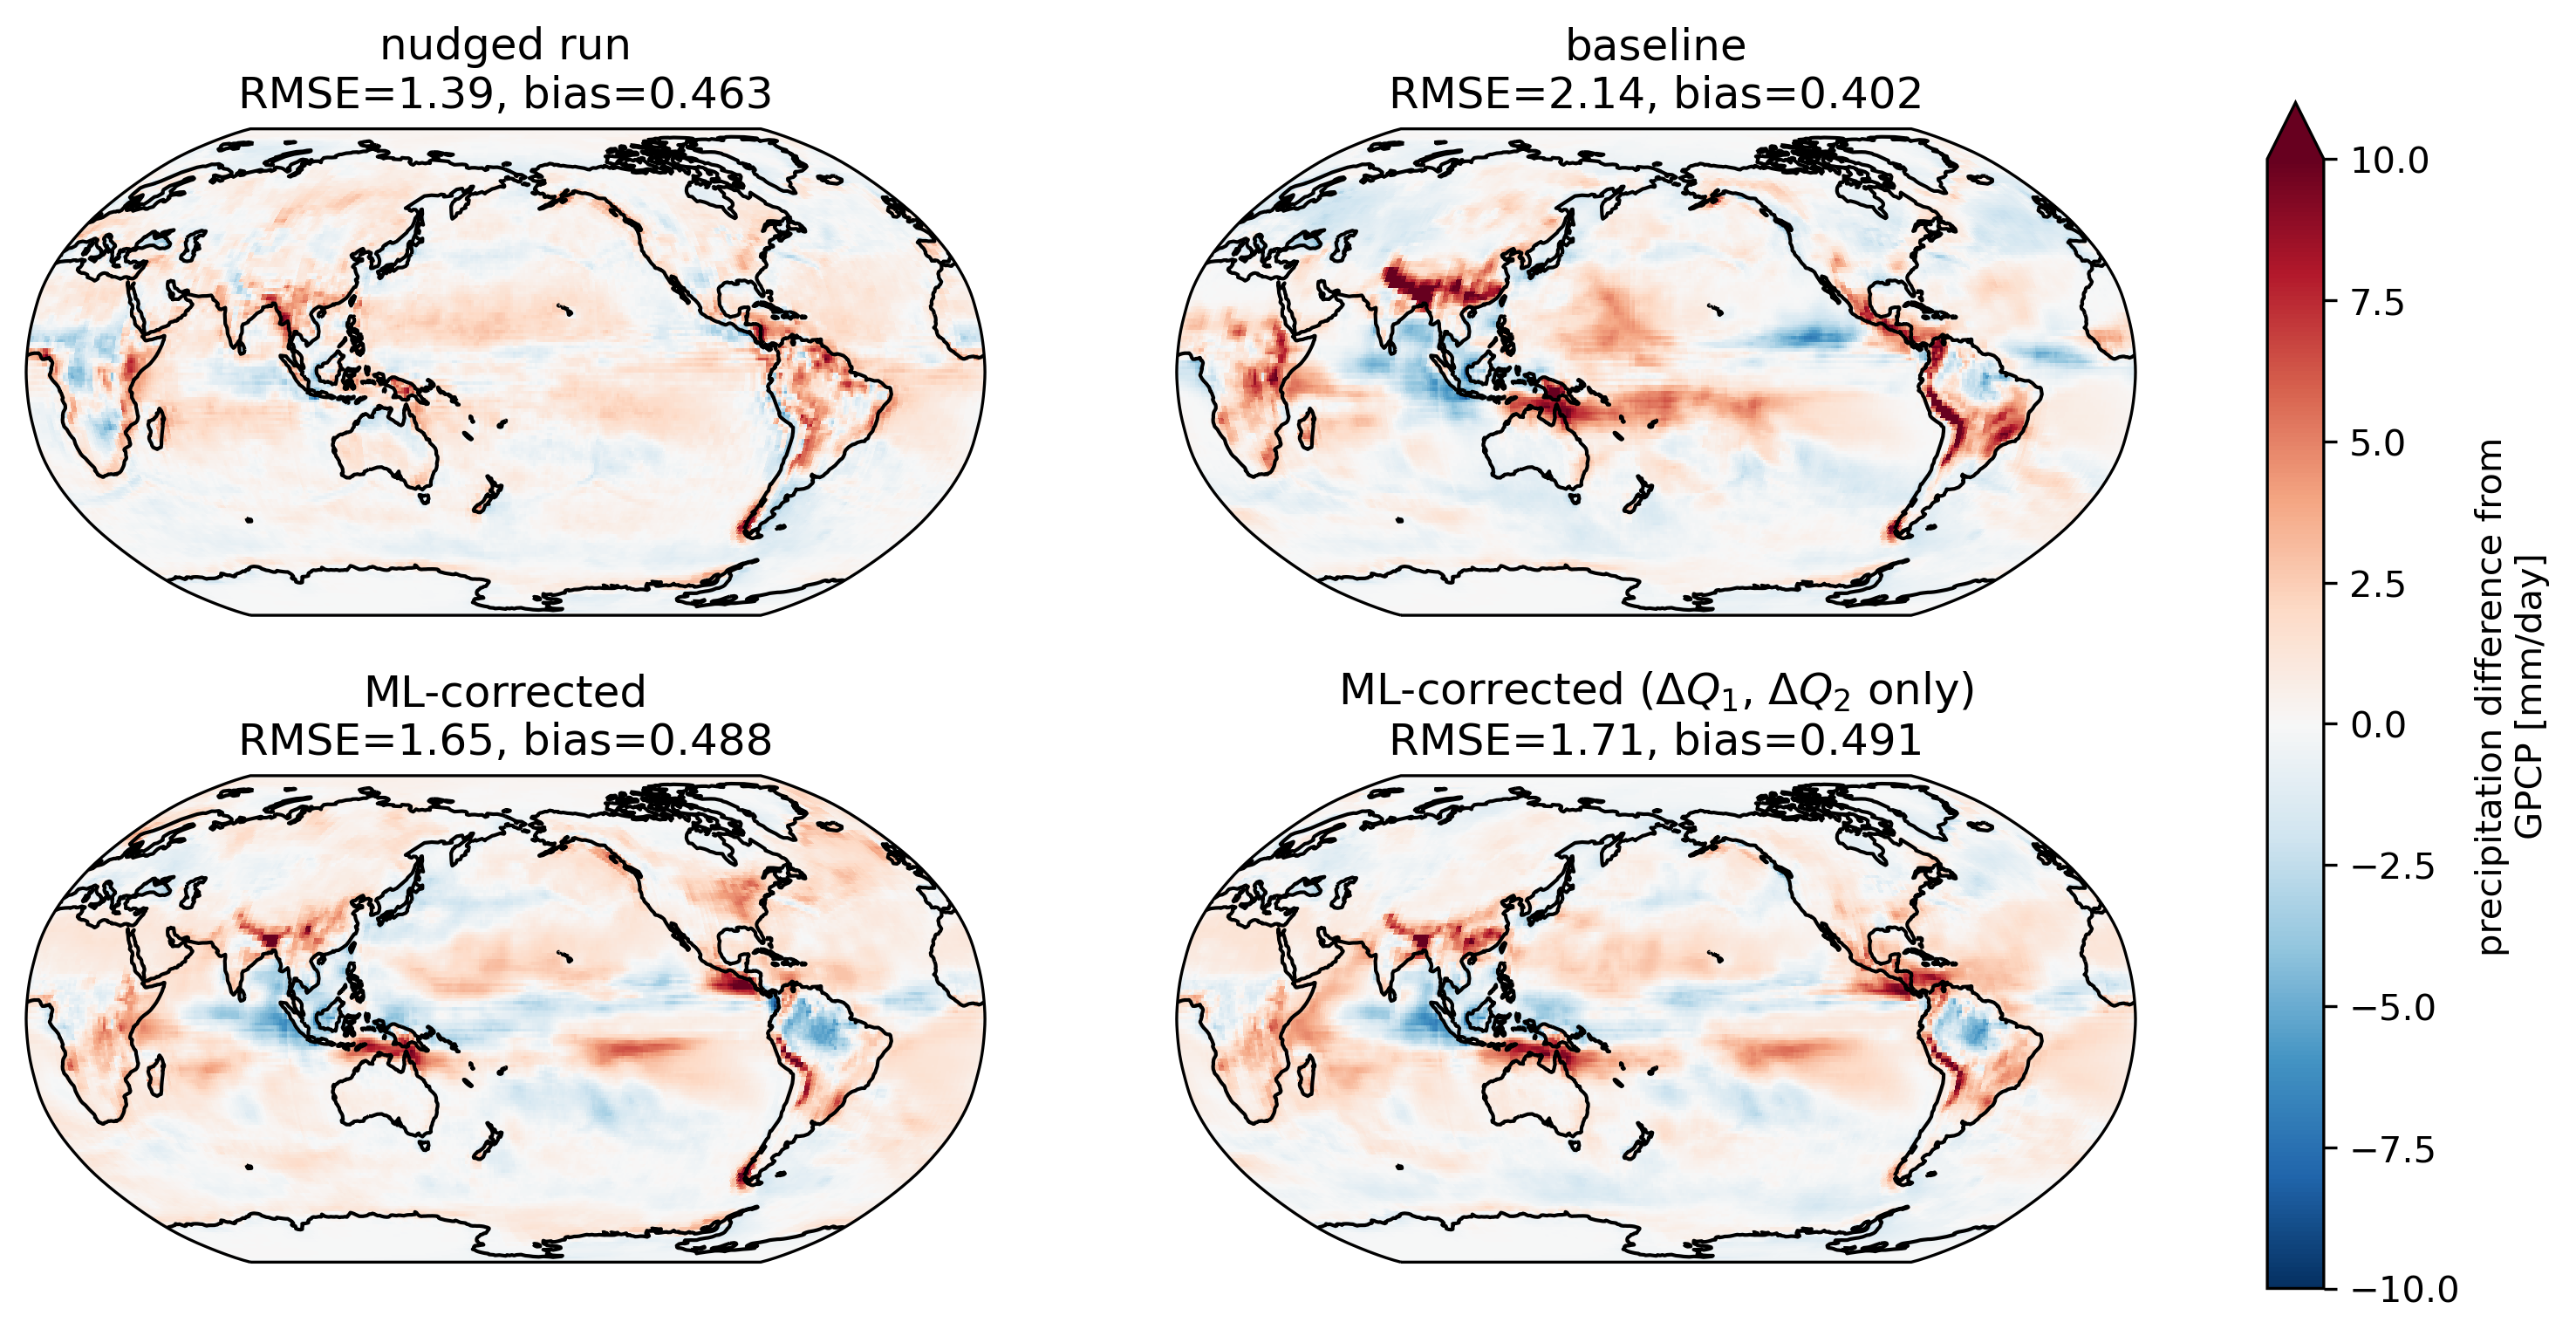

In [11]:
runs = ['nudged run', 'baseline', 'rf-control', 'rf-dQ1-dQ2-only']
fg = precip_bias_from_GPCP.sel(experiment=runs).plot(col='experiment', col_wrap=2, robust=True, vmin=-10, vmax=10, cmap='RdBu_r', **plot_kwargs)
for ax in fg.axes.flat:
    ax.coastlines()
for i, run in enumerate(precip_bias_from_GPCP.sel(experiment=runs).experiment):
    run_label = run.values.item()
    rmse = precip_rmse[run_label]['precip_rmse']
    bias = precip_global_bias[run_label]['precip_bias']
    fg.axes.flat[i].set_title(f"{run_titles[run_label]}\nRMSE={rmse:.3}, bias={bias:.3}")